In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import glob

import cv2
import numpy as np

import torch
from torchvision.transforms.functional import normalize
from gfpgan.archs.gfpganv1_arch import GFPGANv1
from gfpgan.archs.gfpganpyramiddense_arch import GFPGANPyramidDense
from gfpgan.archs.gfpgandense_arch import GFPGANDense
from gfpgan.archs.gfpganpyramid_arch import GFPGANPyramid
from basicsr.utils import img2tensor, tensor2img

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
# from facexlib.utils.face_restoration_helper import FaceRestoreHelper
# face_helper = FaceRestoreHelper(
#     2,
#     face_size=512,
#     crop_ratio=(1.2, 1.2),
#     det_model='retinaface_resnet50',
#     save_ext='png',
#     device='cuda:0'
# )

In [3]:
gfpgan = GFPGANv1(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=1,
    decoder_load_path=None,
    fix_decoder=True,
    num_mlp=8,
    input_is_latent=True,
    different_w=True,
    narrow=1,
    sft_half=True)

# gfpgan = GFPGANDense(
#     out_size=512,
#     num_style_feat=512,
#     channel_multiplier=1,
#     decoder_load_path=None,
#     fix_decoder=True,
#     num_mlp=8,
#     input_is_latent=True,
#     different_w=True,
#     narrow=1,
#     sft_half=True)

In [4]:
gfpgan

GFPGANv1(
  (conv_body_first): ConvLayer(
    (0): EqualConv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0, bias=False)
    (1): FusedLeakyReLU()
  )
  (conv_body_down): ModuleList(
    (0): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1, bias=False)
        (1): FusedLeakyReLU()
      )
      (conv2): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0, bias=False)
        (2): FusedLeakyReLU()
      )
      (skip): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=16, out_channels=32, kernel_size=1, stride=2, padding=0, bias=False)
      )
    )
    (1): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
      

In [5]:
loadnet = torch.load('/home/viu/Work/GFPGAN/experiments/train_GFPGANv1_512_simple_blur2_cx_vanilla/models/net_g_80000.pth')
if 'params_ema' in loadnet:
    keyname = 'params_ema'
else:
    keyname = 'params'
gfpgan.load_state_dict(loadnet[keyname], strict=True)
gfpgan.eval()
gfpgan = gfpgan.to('cuda:0')

In [6]:
tub_faces = glob.glob('/data/datasets/Tubfaces95/validation/strong_tubimages/*.png')
tub_faces.sort()
len(tub_faces)

100

In [7]:
idx = 3
# tub_face_img = cv2.imread('/hdd1/Datasets/Turbulence_data/Victorem_0140__None_PC00C00__R1/001.png', cv2.IMREAD_COLOR)
tub_face_img = cv2.imread(tub_faces[idx], cv2.IMREAD_COLOR)[:,512:]
# face_helper.clean_all()
# face_helper.read_image(tub_face_img)
# face_helper.get_face_landmarks_5(only_center_face=True)
# face_helper.align_warp_face()
# tub_face_img = face_helper.cropped_faces[0]
# tub_face_img = cv2.resize(tub_face_img, (512, 512))

tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
tub_faces[idx]

'/data/datasets/Tubfaces95/validation/strong_tubimages/00004.png'

In [8]:
tub_face_img.shape

(512, 512, 3)

In [9]:
# output = gfpgan(tub_face_img_th, return_rgb=False)[0]
outputs = gfpgan(tub_face_img_th, return_rgb=False)[0]
output = torch.mean(outputs, dim=0)
# restored_face_imgs = []
# for output in outputs:
#     restored_face_img = tensor2img(output.squeeze(0), rgb2bgr=False, min_max=(-1, 1))
#     restored_face_imgs.append(restored_face_img)
    
# restored_face_img = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))
# restored_face_img_compare = np.concatenate([tub_face_img, restored_face_img], axis=1)

In [10]:
# plt.figure(figsize=(18, 10))
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(restored_face_imgs[i])
# plt.savefig('./now.png')

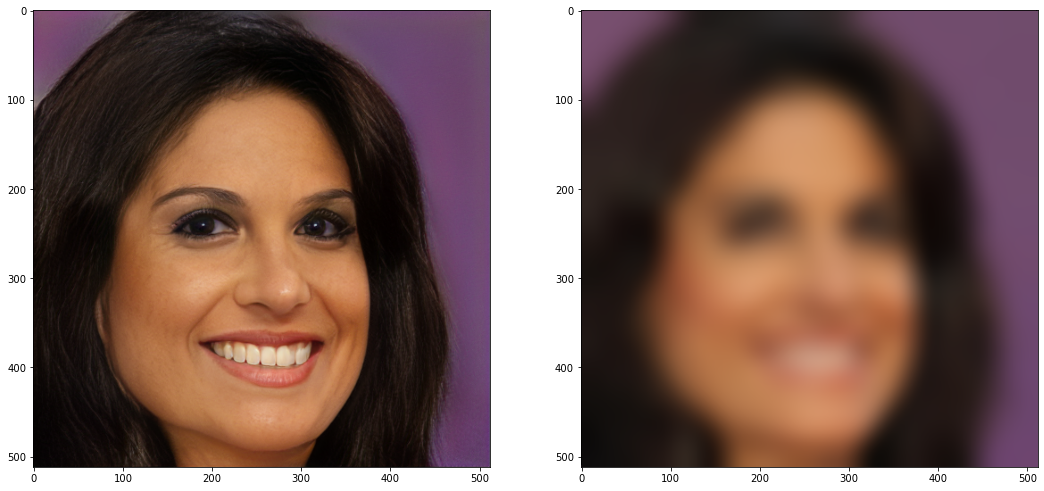

In [11]:
plt.figure(figsize=(18, 12))
plt.subplot(1,2,1)
plt.imshow(tensor2img(output, rgb2bgr=False, min_max=(-1, 1)))

plt.subplot(1,2,2)
plt.imshow(tensor2img(tub_face_img_th, rgb2bgr=False, min_max=(-1, 1)))

In [12]:
for tub_face in tqdm(tub_faces):
    tub_face_img = cv2.imread(tub_face, cv2.IMREAD_COLOR)[:,512:]
    # face_helper.clean_all()
    # face_helper.read_image(tub_face_img)
    # face_helper.get_face_landmarks_5(only_center_face=True)
    # face_helper.align_warp_face()
    # if len(face_helper.cropped_faces) < 1:
    #     print(tub_face)
    #     break
    # tub_face_img = face_helper.cropped_faces[0]

    tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
    normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0')
    outputs = gfpgan(tub_face_img_th, return_rgb=False)[0]
    output = torch.mean(outputs, dim=0)
    # output = gfpgan(tub_face_img_th, return_rgb=False)[0]
    restored_face_img = tensor2img(output.squeeze(0), rgb2bgr=True, min_max=(-1, 1))
 
    # restored_face_img_compare = np.concatenate([tub_face_img, restored_face_img], axis=1)
    cv2.imwrite(os.path.join('/data/datasets/Tubfaces95/validation/comparisons/ab_strong_GFPGANVCX', os.path.basename(tub_face)), restored_face_img)
    # cv2.imwrite(os.path.join('/data/datasets/real_tubface_99/frames/PC00C00_R1_frame_faces', os.path.basename(tub_face)), tub_face_img)


  0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
import torch
from gfpgan.archs.gfpganpyramid_arch import GFPGANPyramid

In [3]:
gfpgan = GFPGANPyramid(
    out_size=512,
    num_style_feat=512,
    channel_multiplier=2,
    decoder_load_path=None,
    fix_decoder=True,
    num_mlp=8,
    input_is_latent=True,
    different_w=True,
    narrow=1,
    sft_half=False)
gfpgan = gfpgan.to('cuda:0')

In [4]:
gfpgan

GFPGANPyramid(
  (conv_body_first): ConvLayer(
    (0): EqualConv2d(in_channels=3, out_channels=32, kernel_size=1, stride=1, padding=0, bias=False)
    (1): FusedLeakyReLU()
  )
  (conv_body_down): ModuleList(
    (0): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
        (1): FusedLeakyReLU()
      )
      (conv2): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=0, bias=False)
        (2): FusedLeakyReLU()
      )
      (skip): ConvLayer(
        (0): UpFirDnSmooth(upsample_factor=1, downsample_factor=2)
        (1): EqualConv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2, padding=0, bias=False)
      )
    )
    (1): ResBlock(
      (conv1): ConvLayer(
        (0): EqualConv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
 

In [5]:
output = gfpgan(torch.rand((1, 3, 512, 512)).cuda(0))[0]

In [6]:
output.shape

torch.Size([4, 1, 3, 512, 512])

In [6]:
output.shape

torch.Size([8, 1, 3, 512, 512])

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from gfpgan.simulator import Simulator

In [6]:
simulator = Simulator(4, 256,
            data_path='../experiments/pretrained_models/turbulence/',
            device=torch.cuda.current_device())
simulator.cuda()       

Simulator(
  (mapping): _P2S(
    (fc1): Linear(in_features=36, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=100, bias=True)
    (fc3): Linear(in_features=100, out_features=100, bias=True)
    (out): Linear(in_features=100, out_features=100, bias=True)
  )
)

In [7]:
from torch.nn import functional as F

tub_face_img = cv2.imread('/data/datasets/ffhq-dataset/sub_images512x512/00000.png', cv2.IMREAD_COLOR)
tub_face_img_th = img2tensor(tub_face_img / 255., bgr2rgb=True, float32=True)
normalize(tub_face_img_th, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
tub_face_img_th = tub_face_img_th.unsqueeze(0).to('cuda:0').contiguous()
tub_face_img_th = F.interpolate(tub_face_img_th, 256, mode='bilinear', align_corners=False)

In [8]:
tub_face_img_th = simulator(tub_face_img_th).unsqueeze(0)
tub_face_img_th = F.interpolate(tub_face_img_th, 512, mode='bilinear', align_corners=False)

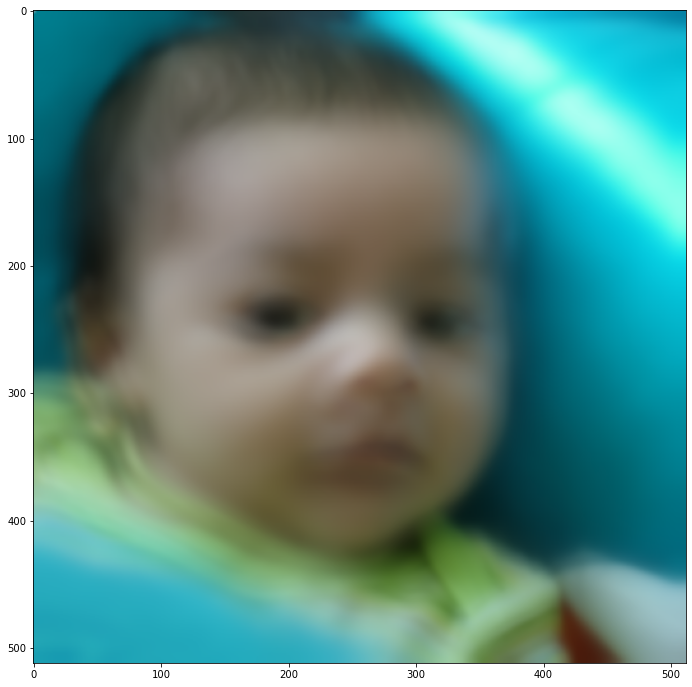

In [9]:
plt.figure(figsize=(12, 12))
plt.imshow(tensor2img(tub_face_img_th, rgb2bgr=False, min_max=(-1, 1)))